# Import Libraries

In [173]:

import os
import numpy as np
import pandas as pd
import sybil_functions
import importlib
from datetime import datetime
from tqdm import tqdm
import requests
from time import sleep
import matplotlib.pyplot as plt
import random
from collections import Counter
import plotly.graph_objects as go


importlib.reload(sybil_functions)

from sybil_functions import (
    read_from_multiple_csv,
    check_df,
    count_pairs,
    remove_contract_transactions,
    stretched_sigmoid,
    get_weight_df,
    plot_weight_dist,
    plot_weight_cumulative_dist,
    create_community,
    community_visualization,
    file_name_lst,
    random_rate,
    find_main_wallet,
    find_transfer_for_wallet,
    find_commu_for_wallet,
    uncommon_wallets,
    filter_community_lst,
    expand_community_lst,
    calculate_likelihoods,
)

In [125]:
os.getcwd()

'/Users/floras/Desktop/unique-user'

In [126]:
# set the path to the focal repository
os.chdir('/Users/floras/Desktop/unique-user')

# Import data

## Contract data

In [127]:
known_contract = read_from_multiple_csv(
    "contract-data",
    file_name_lst("contract-data", startswith="contract", endswith="moca_airdrop.csv"),
)
print(known_contract.shape)
known_contract.head()

(91, 4)


,address,contract/public account,sus,note
0,0x76dd65529dc6c073c1e0af2a5ecc78434bdbf7d9,y,NaN,NaN
1,0xe50ddf54c958a63ec1f2ab4fd48c899de7bfaa0b,NaN,y,"high-frequency in on polygon, mainly from 0x29..."
2,0x9008d19f58aabd9ed0d60971565aa8510560ab41,y,NaN,NaN
3,0x9a98e6b60784634ae273f2fb84519c7f1885aed2,y,NaN,moca staking
4,0xdc066677b5ee2c577132b69ac13da6cf8a50c1c7,y,NaN,NaN


## White list

In [128]:
known_white = read_from_multiple_csv(
    "white-data",
    file_name_lst("white-data", startswith="white", endswith="moca_airdrop.csv"),
)
white_set = set(known_white["address"])
print(known_white.shape)
known_white.head()

(176, 2)


,address,Unnamed: 1
0,0xba1c4b823a1d9ba7c8e3012d6ec4f57d7ddfe501,NaN
1,0xdd3d60296fd6c7e57fbe7d67472f708c178f4d29,NaN
2,0x31ea111ebe1963d409ae5731d8bb58975a4e187c,NaN
3,0xf8e9263f3e4485900634757ed34288d656cd3c99,NaN
4,0xda2495e2ee77469a471c946e334eed38d0179fd2,NaN


## Moca Airdrop Receiver Info

In [129]:
moca_airdrop_df = pd.read_excel('moca-airdrop/data/moca_airdrop_user_info.xlsx')
moca_airdrop_df.head()

,email,uuid,uuid.1,moca_id,id,name,abstract_account_address,web3auth_wallet_address,address,id.1,uuid.2,user_id
0,NaN,0016e1a3-0cdf-475b-b921-2d121453bece,0016e1a3-0cdf-475b-b921-2d121453bece,kppytiuynykiboo,7418689.0,kppytiuynykiboo,0x4b5591379a65c0180103f421cce640c679d1d9d8,0xc0f32955a9b37e6c1fa235a4f330c2d23545af88,0xc0f32955a9b37e6c1fa235a4f330c2d23545af88,590112.0,2d45d118-3d6f-4c7f-930d-5c9f3d56f612,7418689.0
1,semidmitrii@gmail.com,00284435-f796-45ad-8c61-5cf4a5417043,00284435-f796-45ad-8c61-5cf4a5417043,therock,25939.0,therock,0x3f1f1694941ebea878fe9e88b048dcb6f0c8f07b,0x5335b140366404b2bd875339322de16f9cd9651c,0xe23308c15434f903825112035cc1d26914fab078,60816.0,6ee964db-f14c-49ad-84db-84d937463cb3,25939.0
2,NaN,0048b42e-7630-42a2-9633-9ee78c35f2eb,0048b42e-7630-42a2-9633-9ee78c35f2eb,mocae,7361874.0,mocae,0x38c24c4158033ef3967f102748cba1d56079bd31,0x9c590bb4e0ffb4c9adfc03dfa2ee2484502ce067,0x9c590bb4e0ffb4c9adfc03dfa2ee2484502ce067,43567.0,5cbe41a2-b90c-43cb-9560-af5cb0cb2b2f,7361874.0
3,NaN,00799be0-8c24-4f0b-a442-bbb1279a63d3,00799be0-8c24-4f0b-a442-bbb1279a63d3,accelerando,8000019.0,accelerando,0xd86b10033c4d718b9b5f330ab270cd17c31cba97,0xaa6c6d0ed231da328814c2b7853d2e4350b70000,0xaa6c6d0ed231da328814c2b7853d2e4350b70000,294969.0,182f98d8-9098-4763-be3d-4e47985beb8f,8000019.0
4,NaN,00799be0-8c24-4f0b-a442-bbb1279a63d3,00799be0-8c24-4f0b-a442-bbb1279a63d3,accelerando,8000019.0,accelerando,0xd86b10033c4d718b9b5f330ab270cd17c31cba97,0xaa6c6d0ed231da328814c2b7853d2e4350b70000,0xd1f01c4bc479967f4dbde0a73f961dd14afa524f,343872.0,abe31f57-dcd4-4bec-a434-414e2c0d2181,8000019.0


In [130]:
moca_airdrop_df['address'].nunique()

29164

### Addresses with more than 1 Moca ID

In [131]:
addresses_with_more_than_one = moca_airdrop_df["address"].value_counts()
addresses_with_more_than_one = addresses_with_more_than_one[
    addresses_with_more_than_one > 1
]
addresses_with_more_than_one = addresses_with_more_than_one.index.tolist()

print(addresses_with_more_than_one)

['0x7646c2e54f972ea0def55b66b4f05416acd49db0', '0x916b0395e409bdcda99294fb5094d3492c0933cd', '0xfd1b9568fcdaee267c98f45070f27e17a82ffe43', '0x030e8df34cb8eca071b813472b4ac7822f39896d', '0x1611009da0dd85f772ef8fcff5de1a5cfdff8f97', '0x53078efd332cf24bc158804b7ac92e0cf6171327', '0x34e667710c5f5fbf366023fa1664bfc71e4bb2ae', '0x88720be48c436b763eb3978198a5261a856c9725', '0x65f8f6fc92d58aa586da5b678c994e1413d9e939']


### Wallet list and wallet set

In [132]:
wallet_lst = moca_airdrop_df["address"]
wallet_lst = wallet_lst.str.lower()
wallet_lst = [x for x in wallet_lst if x not in set(addresses_with_more_than_one)]

wallet_set = set(wallet_lst)
wallet_lst = list(wallet_set)
print(len(wallet_lst))

29156


## Native token transfer data

In [133]:
native_trans_path = 'moca-airdrop/data/raw-data'

In [134]:
native_trans_file_lst = file_name_lst(
    native_trans_path, startswith="native", endswith=".csv"
)
native_trans_df_0 = read_from_multiple_csv(native_trans_path, native_trans_file_lst)
native_trans_df_0 = native_trans_df_0[
    native_trans_df_0["from_address"].isin(wallet_set)
    | native_trans_df_0["to_address"].isin(wallet_set)
]
native_trans_df_0 = native_trans_df_0[
    (native_trans_df_0["from_address"].isna() == False)
    & (native_trans_df_0["to_address"].isna() == False)
]
native_trans_df_0.columns = ["timestamp", "from_address", "to_address", "native_tx_count"]
print(native_trans_df_0.shape)
native_trans_df_0.head()

(180673, 4)


,timestamp,from_address,to_address,native_tx_count
0,2024-06-01 00:00:00.000 UTC,0xbb14ed78c9fc563e5263bc3502fa86aec887194b,0xca3840c43962aa4857f9237463825071cb7da071,10
1,2024-06-01 00:00:00.000 UTC,0xf36f26f3d31f58772c99321fafed6729c3f47f5e,0xa137e8b1ff0339328572bad9c788c23586eaa63c,28
2,2024-06-01 00:00:00.000 UTC,0xda1bbc89a1deeed513363654324a0ebb17946ee0,0x6c5e87309ee7ff13628cc8c8dbb5fbbb4cb7ca5c,29
3,2024-06-01 00:00:00.000 UTC,0xf0cbace7452b530aa18ff0870e3475ec71ba362b,0x95a7f9cd4db3564146599267f7848fe20ad5c59e,1
4,2024-06-01 00:00:00.000 UTC,0xf327d13cd7bc9b3ea7485a97dfbbd0cc998635b8,0x6b1e3ddecc11583ed189b1db217873aa1c65a72e,1


## Moca coin transfer data

In [135]:
moca_trans_path = 'moca-airdrop/data/raw-data'

In [136]:
moca_trans_file_lst = file_name_lst(
    moca_trans_path, startswith="mocacoin", endswith=".csv"
)
moca_trans_df_0 = read_from_multiple_csv(moca_trans_path, moca_trans_file_lst)
moca_trans_df_0 = moca_trans_df_0[
    moca_trans_df_0["from_address"].isin(wallet_set)
    | moca_trans_df_0["to_address"].isin(wallet_set)
]
moca_trans_df_0.columns = ["from_address", "to_address", "moca_tx_count"]
moca_trans_df_0

,from_address,to_address,moca_tx_count
0,0x6b22ca1ba7fc8d7f96cdb13ab68f082c27ed78d3,0x4c510f3b6e4190037c24fdb41fcb4c312a42c3e3,2
1,0x02c97159c1b3ca84b919ce26e8fc97150f410413,0x70b4463181ed9a4079d4917327af63cfdac3bc3f,1
2,0x8d25e246a03f9f20444f13576e8fdc6e7f188eca,0x8d25e246a03f9f20444f13576e8fdc6e7f188eca,1
3,0x1629d7c04d64336eb61426d602f530609cb57b75,0x1ea319d90011c17e8f144552f1f75d7a3f8916d6,1
4,0x50c49098c25d69136c0592154b4d5d4c0e1fa84b,0xff85a314a083c947238972aad732814a83c9a4af,1
...,...,...,...
7752,0x9a98e6b60784634ae273f2fb84519c7f1885aed2,0x6b5bdd4dc61ff37d1ac5d5c35b100cd643c4b2da,1
7753,0xeca741697c604b0f7acf3112beb28f07567671bb,0xdaee8684102f80b7c39a7ea300a234bf42a01588,1
7754,0x9a98e6b60784634ae273f2fb84519c7f1885aed2,0x20336a028b81251219ce5342959ed79826cac3f5,1
7755,0x9a98e6b60784634ae273f2fb84519c7f1885aed2,0x2c4be594c174690c22701333d0f96efe3fddc836,1


# Remove contract transactions

In [137]:
# wallet_to_test = list(set(trans_df["from_address"].unique()).union(set(trans_df["to_address"].unique())))
# wallet_to_test = uncommon_wallets(wallet_to_test, balance_df['wallet_address'])
# wallet_to_test = uncommon_wallets(wallet_to_test, known_contract['address'])

# print(len(wallet_to_test))

In [138]:
# # loop through all addresses
# new_found_contract_lst = []

# for i in tqdm(range(494, len(wallet_to_test))):
#     sleep(0.15)
#     address = list(wallet_to_test)[i]
#     # oklink api
#     url = f"https://www.oklink.com/api/v5/explorer/eth/api?module=contract&action=getabi&address={address}"
#     headers = {"Ok-Access-Key": "f0f1e2ec-7e9a-470d-aa0f-a436cc55c2e6"}
#     response = requests.request(method="GET", url=url, headers=headers)
#     response_json = response.json()

#     try:
#         if response_json["status"] == "1":
#             new_found_contract_lst.append(address)
#             print(f"Address: {address}")
#     except:
#         print(f"Error in getting info for: {address}")
#         print(response_json)
#         pass

In [139]:
# # add the new found contract to the end of contract_ape_holder.csv
# new_found_contract_df = pd.DataFrame(new_found_contract_lst, columns=["address"])
# new_found_contract_df.to_csv(
#     "edu/data/processed_data/contract_ape_holder.csv",
#     index=False,
#     mode="a",
#     header=False,
# )

In [140]:
# check size
print("native: ", native_trans_df_0.shape[0])
print("moca: ", moca_trans_df_0.shape[0])
print("")

# remove contract transactions
native_trans_df_0 = remove_contract_transactions(
    native_trans_df_0, ["from_address", "to_address"], known_contract["address"]
)
moca_trans_df_0 = remove_contract_transactions(
    moca_trans_df_0, ["from_address", "to_address"], known_contract["address"]
)

# check size
print("native: ", native_trans_df_0.shape[0])
print("moca: ", moca_trans_df_0.shape[0])
print("")

# remove non_wallet_to transactions
native_trans_df = native_trans_df_0.copy()
moca_trans_df = moca_trans_df_0.copy()

# check size
print("native: ", native_trans_df.shape[0])
print("moca: ", moca_trans_df.shape[0])
print("")

trans_df = pd.concat([native_trans_df, moca_trans_df], ignore_index=True)
print("total: ", trans_df.shape[0])

native:  180673
moca:  7744

native:  161297
moca:  3521

native:  161297
moca:  3521

total:  164818


# Get transaction counts

## For native

In [141]:
native_trans_df_count = native_trans_df.copy()
native_trans_df_count["pair"] = native_trans_df_count.apply(
    lambda x: tuple(sorted([x["to_address"], x["from_address"]])), axis=1
)

# Sum the transaction counts for each wallet pair
native_trans_df_count = native_trans_df_count.groupby("pair")["native_tx_count"].sum()
native_trans_df_count = pd.DataFrame(native_trans_df_count)
native_trans_df_count = get_weight_df(native_trans_df_count)
native_trans_df_count = native_trans_df_count.sort_values(
    by="native_tx_count", ascending=False
)

# if no need to check
native_trans_df_count["if_wallet_a"] = native_trans_df_count["wallet_a"].isin(
    wallet_set.union(white_set)
)
native_trans_df_count["if_wallet_b"] = native_trans_df_count["wallet_b"].isin(
    wallet_set.union(white_set)
)

# native_trans_df_count = native_trans_df_count.sort_values(by='tx_count', ascending=False)
native_trans_df_count[
    ~native_trans_df_count["if_wallet_a"] | ~native_trans_df_count["if_wallet_b"]
].head(20)

,pair,native_tx_count,wallet_a,wallet_b,if_wallet_a,if_wallet_b
69156,"(0x7ac79c369a3585b19e068578d37916259e497616, 0...",113,0x7ac79c369a3585b19e068578d37916259e497616,0xaec37292d361417610977045d863500907762712,True,False
12668,"(0x1052a3af2476e5c39a05c07c75135af81ad8cae5, 0...",113,0x1052a3af2476e5c39a05c07c75135af81ad8cae5,0xcae756ac91bdafd828dae5ae6b6c83b8d509583e,False,True
64590,"(0x6fe0c938f6c5059597081a5738407f8610e72cd2, 0...",110,0x6fe0c938f6c5059597081a5738407f8610e72cd2,0xecbce6a0e79c5a3060879fed54dbee62b032250b,False,True
68315,"(0x78aba45e3cc94b7bbf163f34aebfb1d02a2f2308, 0...",110,0x78aba45e3cc94b7bbf163f34aebfb1d02a2f2308,0xb0b50a71b450643188c7bf56ebc2dbe1ee7a3037,True,False
44800,"(0x45c25565541575a8167495c6ca470310e38c805d, 0...",109,0x45c25565541575a8167495c6ca470310e38c805d,0xfcfefaadf519499bd661fce55918a244d334c500,True,False
88954,"(0xbe5072933fca2523ea9b060937c4b784405933dc, 0...",107,0xbe5072933fca2523ea9b060937c4b784405933dc,0xf9329d35fd7a87e2aa87a51acd4863dc50be0d4c,True,False
89147,"(0xbf66ed3c3fde88f2ca462b218755ea46258e543c, 0...",106,0xbf66ed3c3fde88f2ca462b218755ea46258e543c,0xf21dfbf90dab607635291120aa4577f3c0b04d0c,False,True
21723,"(0x1e8958b0771533c95407c40a45f913d945e0b7db, 0...",105,0x1e8958b0771533c95407c40a45f913d945e0b7db,0xa4446eb85b69fca6c2cb50b3eb235f5e299a4bde,False,True
25361,"(0x23ee9f950168b5b8938e09b2f07e08b9a7a70d79, 0...",105,0x23ee9f950168b5b8938e09b2f07e08b9a7a70d79,0xdf8dd5e0b4168f20a3488ad088ddb198fe602cb3,True,False
38751,"(0x3a06bce5a2d5bccba7b51018b4673dff9450bbe9, 0...",104,0x3a06bce5a2d5bccba7b51018b4673dff9450bbe9,0x602faee794e16604fbb17511b1ad179a728ce61b,False,True


## For MocaCoin

In [142]:
moca_trans_df_count = moca_trans_df.copy()
moca_trans_df_count['pair'] = moca_trans_df_count.apply(lambda x: tuple(sorted([x['to_address'], x['from_address']])), axis=1)

# Sum the transaction counts for each wallet pair
moca_trans_df_count = moca_trans_df_count.groupby('pair')['moca_tx_count'].sum()
moca_trans_df_count = pd.DataFrame(moca_trans_df_count)
moca_trans_df_count = get_weight_df(moca_trans_df_count)
moca_trans_df_count = moca_trans_df_count.sort_values(by='moca_tx_count', ascending=False)

# if no need to check
moca_trans_df_count['if_wallet_a'] = moca_trans_df_count["wallet_a"].isin(wallet_set.union(white_set))
moca_trans_df_count['if_wallet_b'] = moca_trans_df_count["wallet_b"].isin(wallet_set.union(white_set))

# pol_trans_df_count = pol_trans_df_count.sort_values(by='tx_count', ascending=False)
moca_trans_df_count[~moca_trans_df_count['if_wallet_a'] | ~moca_trans_df_count['if_wallet_b']].head(20)

,pair,moca_tx_count,wallet_a,wallet_b,if_wallet_a,if_wallet_b
2106,"(0x6313d7948d3491096ffe00dea2d246d588b4d4fc, 0...",2,0x6313d7948d3491096ffe00dea2d246d588b4d4fc,0xd91efec7e42f80156d1d9f660a69847188950747,True,False
2146,"(0x65cccf23a99b0163dfe279d35b83194b83633807, 0...",2,0x65cccf23a99b0163dfe279d35b83194b83633807,0xcf50c596eafbfbf301f3a9983189ecdb78200301,True,False
332,"(0x0d10e1ab159c413e58a6717ae30bd2a6cbd2a4ba, 0...",2,0x0d10e1ab159c413e58a6717ae30bd2a6cbd2a4ba,0x4d24d86aa1c5f70bcb875241f6ea0c609f15707c,False,True
2835,"(0x97ef3f7720baee010e6714347fa13b478e2b1491, 0...",2,0x97ef3f7720baee010e6714347fa13b478e2b1491,0xe517f5274a21c74ae230d99010ad11992d0e836b,False,True
2412,"(0x78f7d94fde86903a51d248da04b6e606bd301511, 0...",2,0x78f7d94fde86903a51d248da04b6e606bd301511,0xa99c12251ed08b62447c5c03bab8ba95930e8f61,True,False
620,"(0x1a3a27e789b14b23ef86105b235695f1dce27fbc, 0...",2,0x1a3a27e789b14b23ef86105b235695f1dce27fbc,0xfba60ab7624b17e23627e6062b094ea203f5c91e,True,False
411,"(0x1111111254eeb25477b68fb85ed929f73a960582, 0...",2,0x1111111254eeb25477b68fb85ed929f73a960582,0xf1d0e6348d64d287288b5518911a816e3361cb1f,False,True
1188,"(0x31b699415119b47fda845889a4ed161bb33e3826, 0...",2,0x31b699415119b47fda845889a4ed161bb33e3826,0xeb5472754882c7f6662728daa655321f2d28f5ac,False,True
168,"(0x063dfb3f0abf2180655a3994e72fc062a66968b4, 0...",2,0x063dfb3f0abf2180655a3994e72fc062a66968b4,0x8b5b1519222035b9c967e5f674be2a05b7f53887,False,True
2485,"(0x7e46caf20338cedcf3fd61dafa7ad003d0d2ff75, 0...",2,0x7e46caf20338cedcf3fd61dafa7ad003d0d2ff75,0xf17cd420b438529c27eaff9e0ba10ef3ac2560ac,False,True


## Concate and get transaction count again

In [143]:
print(len(native_trans_df_count))
print(len(moca_trans_df_count))

trans_df_count = pd.concat(
    [
        native_trans_df_count[["pair", "native_tx_count"]],
        moca_trans_df_count[["pair", "moca_tx_count"]],
    ],
    ignore_index=True,
)
trans_df_count = trans_df_count.fillna(0)
check_df(trans_df_count)

95823
3514


(99337, 3)

pair                object
native_tx_count    float64
moca_tx_count      float64
dtype: object

,native_tx_count,moca_tx_count
count,99337.000000,99337.000000
mean,2.304076,0.038193
std,7.335441,0.215171
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,2.000000,0.000000
max,503.000000,8.000000


,pair,native_tx_count,moca_tx_count
0,"(0x8987c16b215bbff137a6a7198117457e16a7e59a, 0...",503.0,0.0
1,"(0xba1c4b823a1d9ba7c8e3012d6ec4f57d7ddfe501, 0...",483.0,0.0
2,"(0x66f8195745387eaae67e19a6ef0257b40aeb8124, 0...",403.0,0.0
3,"(0x31ea111ebe1963d409ae5731d8bb58975a4e187c, 0...",370.0,0.0
4,"(0x9e718ecbf799498809b6d0183f46e2941344c9a9, 0...",323.0,0.0


In [144]:
trans_df_count = trans_df_count.groupby('pair').agg({
    'native_tx_count': 'sum',
    'moca_tx_count': 'sum'
})
trans_df_count = pd.DataFrame(trans_df_count)
trans_df_count = get_weight_df(trans_df_count)

# if in holder lst
trans_df_count['if_wallet_a'] = trans_df_count["wallet_a"].isin(wallet_set)
trans_df_count['if_wallet_b'] = trans_df_count["wallet_b"].isin(wallet_set)

trans_df_count = trans_df_count.sort_values(by='native_tx_count', ascending=False)

In [145]:
check_df(trans_df_count)

(98876, 7)

pair                object
native_tx_count    float64
moca_tx_count      float64
wallet_a            object
wallet_b            object
if_wallet_a           bool
if_wallet_b           bool
dtype: object

,native_tx_count,moca_tx_count
count,98876.000000,98876.000000
mean,2.314819,0.038371
std,7.350831,0.215656
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,2.000000,0.000000
max,503.000000,8.000000


,pair,native_tx_count,moca_tx_count,wallet_a,wallet_b,if_wallet_a,if_wallet_b
77286,"(0x8987c16b215bbff137a6a7198117457e16a7e59a, 0...",503.0,0.0,0x8987c16b215bbff137a6a7198117457e16a7e59a,0x92df3900d9586611c3d60b22d28498958d0f89ad,True,True
90841,"(0xba1c4b823a1d9ba7c8e3012d6ec4f57d7ddfe501, 0...",483.0,0.0,0xba1c4b823a1d9ba7c8e3012d6ec4f57d7ddfe501,0xcbffd9f33015af12383a0f210b4f37383386bbe9,False,True
62925,"(0x66f8195745387eaae67e19a6ef0257b40aeb8124, 0...",403.0,0.0,0x66f8195745387eaae67e19a6ef0257b40aeb8124,0xdd3d60296fd6c7e57fbe7d67472f708c178f4d29,True,False
34860,"(0x31ea111ebe1963d409ae5731d8bb58975a4e187c, 0...",370.0,0.0,0x31ea111ebe1963d409ae5731d8bb58975a4e187c,0x463c507e8b2ddc6aea0e45a736b3bf8b210bb36d,False,True
83878,"(0x9e718ecbf799498809b6d0183f46e2941344c9a9, 0...",323.0,0.0,0x9e718ecbf799498809b6d0183f46e2941344c9a9,0xd93f89eb91974e5ba75d2aed0d625741065bf537,True,True


### keep only wallet pairs with transactions in both native and moca

In [146]:
### keep only wallet pairs with transactions in both native and moca
trans_df_count = trans_df_count[
    trans_df_count["if_wallet_a"] | trans_df_count["if_wallet_b"]
]

# Transaction count -> Weight

In [147]:
# set sigmoid parameters
stretch = 1

In [148]:
weight_df = trans_df_count.copy()

# Revise the if_wallet_a and if_wallet_b columns
weight_df["if_wallet_a"] = weight_df["wallet_a"].isin(wallet_set)
weight_df["if_wallet_b"] = weight_df["wallet_b"].isin(wallet_set)

# Calculate the internal weight
weight_df["moca_weight"] = weight_df.apply(
    lambda x: (stretched_sigmoid(x["moca_tx_count"], stretch) - 0.5) * 5, axis=1
)

# Calculate the total weight
weight_df["native_weight"] = weight_df.apply(
    lambda x: stretched_sigmoid(x["native_tx_count"], stretch) - 0.5,
    axis=1,
)

weight_df["weight"] = weight_df["moca_weight"] + weight_df["native_weight"]

# Sort based on weight
weight_df = weight_df.sort_values(by="weight", ascending=False)

In [149]:
check_df(weight_df)

(98876, 10)

pair                object
native_tx_count    float64
moca_tx_count      float64
wallet_a            object
wallet_b            object
if_wallet_a           bool
if_wallet_b           bool
moca_weight        float64
native_weight      float64
weight             float64
dtype: object

,native_tx_count,moca_tx_count,moca_weight,native_weight,weight
count,98876.000000,98876.000000,98876.000000,98876.000000,98876.000000
mean,2.314819,0.038371,0.042647,0.292748,0.335395
std,7.350831,0.215656,0.225262,0.111998,0.206260
min,0.000000,0.000000,0.000000,0.000000,0.231059
25%,1.000000,0.000000,0.000000,0.231059,0.231059
50%,1.000000,0.000000,0.000000,0.231059,0.231059
75%,2.000000,0.000000,0.000000,0.380797,0.380797
max,503.000000,8.000000,2.498323,0.500000,2.986726


,pair,native_tx_count,moca_tx_count,wallet_a,wallet_b,if_wallet_a,if_wallet_b,moca_weight,native_weight,weight
32661,"(0x2e6ef714225ae97647305fe6e3d23adebf95161f, 0...",7.0,6.0,0x2e6ef714225ae97647305fe6e3d23adebf95161f,0xb5d19f46aeb528b8d698fca297d38a3e55461513,True,False,2.487637,0.499089,2.986726
4422,"(0x04898c077eb5f6e3dc5f6086cd96ceeed523cd81, 0...",4.0,6.0,0x04898c077eb5f6e3dc5f6086cd96ceeed523cd81,0x0e209f2bf981399b1cf7cd4054e2a78efc56ba55,True,False,2.487637,0.482014,2.969651
80376,"(0x9283b44a6e4b5c12ad3ed2a56dff38d4496e2506, 0...",13.0,5.0,0x9283b44a6e4b5c12ad3ed2a56dff38d4496e2506,0x9985d0fd7bc0fc7b16cc68ad6f30ec8e1d02af86,True,False,2.466536,0.499998,2.966533
23966,"(0x211cea4e6e15457f2e92c611714e7b11b0738055, 0...",5.0,5.0,0x211cea4e6e15457f2e92c611714e7b11b0738055,0xea5f4f4440ff3cc417d09b43d6f8da1f14175846,True,True,2.466536,0.493307,2.959843
90548,"(0xb8b17ccd40cb726cff486c6cfc23bcf1111fe685, 0...",3.0,6.0,0xb8b17ccd40cb726cff486c6cfc23bcf1111fe685,0xc7f2886d1ac8e743a3a45aaefffeea3ca21dff21,False,True,2.487637,0.452574,2.940211


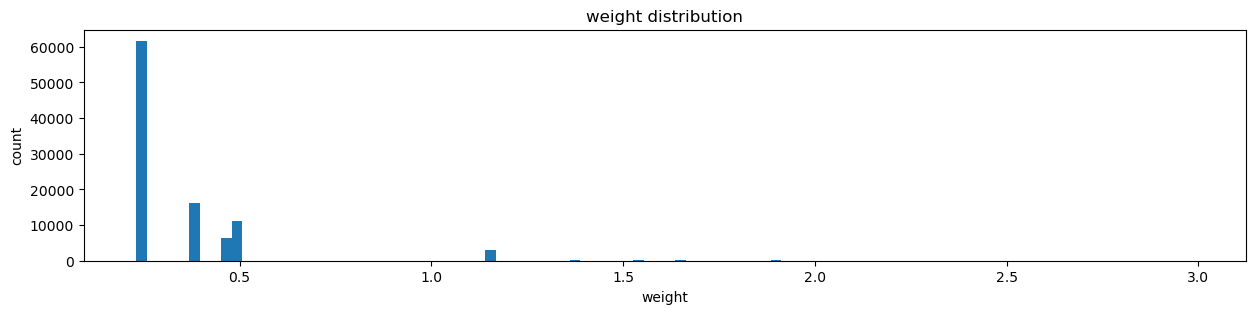

In [150]:
plot_weight_dist(weight_df)

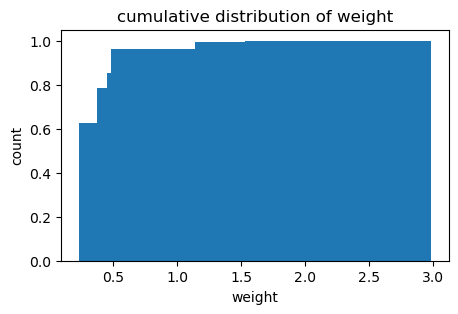

In [151]:
plot_weight_cumulative_dist(weight_df)

# Weight -> Community

In [152]:
resolution_value = 225

In [153]:
print(f'resultion: {resolution_value}')
community_lst_lou, G_lou = create_community(weight_df, "louvain", resolution = resolution_value)

# community_lst_s = create_community(weight_df, 'surprise')
# community_lst_lei = create_community(weight_df, 'leiden')

resultion: 225
Method: louvain
Number of unique wallets: 89936
Number of edges: 98876
Number of communities detected: 11396
-
Average community size: 7.891891891891892
Max community size: 501
Min community size: 1



In [156]:
# get the wallet likelihood of louvain
wallet_likelihood_lou = calculate_likelihoods(community_lst_lou, G_lou)

In [157]:
# get the wallet likelihood df
wallet_likelihood_df = pd.DataFrame(wallet_likelihood_lou).T.reset_index(drop=False)
wallet_likelihood_df["if_airdrop"] = wallet_likelihood_df["index"].isin(wallet_set)
wallet_likelihood_df['if_white'] = wallet_likelihood_df['index'].isin(white_set)

In [249]:
# row_lst = range(10)
row_lst = [44]
community_lst_visualization_1 = community_lst_lou

# get the wallet info of the current community
wallet_info_df_1 = wallet_likelihood_df[
    wallet_likelihood_df["community"] == row_lst[0]
]

for row in row_lst:
    community = community_lst_visualization_1[row]
    print("Size of community:", len(community))
    # print(find_main_wallet(community, weight_df))

    commu_visual_df_1 = weight_df.loc[
        weight_df["wallet_a"].isin(community) & weight_df["wallet_b"].isin(community)
    ]

    print("Average weight:", commu_visual_df_1["weight"].mean())

Size of community: 73
Average weight: 0.36791091317576546


In [176]:
commu_visual_df_1

,pair,native_tx_count,moca_tx_count,wallet_a,wallet_b,if_wallet_a,if_wallet_b,moca_weight,native_weight,weight
16341,"(0x15534128e89e302288e2bc97495b83795c0d2f6b, 0...",16.0,0.0,0x15534128e89e302288e2bc97495b83795c0d2f6b,0x744fc2e89e825f9ec2c1619915420a6b66b030ff,True,False,0.0,0.500000,0.500000
16410,"(0x15534128e89e302288e2bc97495b83795c0d2f6b, 0...",9.0,0.0,0x15534128e89e302288e2bc97495b83795c0d2f6b,0xd61f6e2ae0a82f7d383b01feca290ba03f7443bf,True,False,0.0,0.499877,0.499877
16294,"(0x15534128e89e302288e2bc97495b83795c0d2f6b, 0...",8.0,0.0,0x15534128e89e302288e2bc97495b83795c0d2f6b,0x30a595f98c697f575e27d648294167c496780583,True,False,0.0,0.499665,0.499665
16316,"(0x15534128e89e302288e2bc97495b83795c0d2f6b, 0...",8.0,0.0,0x15534128e89e302288e2bc97495b83795c0d2f6b,0x51975b1710475959f2853a06ac4b3b9af0cd8ac6,True,False,0.0,0.499665,0.499665
16290,"(0x15534128e89e302288e2bc97495b83795c0d2f6b, 0...",7.0,0.0,0x15534128e89e302288e2bc97495b83795c0d2f6b,0x24f2541c51dde580896a7d0d2765824b2f45424e,True,False,0.0,0.499089,0.499089
...,...,...,...,...,...,...,...,...,...,...
16363,"(0x15534128e89e302288e2bc97495b83795c0d2f6b, 0...",1.0,0.0,0x15534128e89e302288e2bc97495b83795c0d2f6b,0x9bcdefd6c07e1ba5739c0515d275091619d8db19,True,False,0.0,0.231059,0.231059
16364,"(0x15534128e89e302288e2bc97495b83795c0d2f6b, 0...",1.0,0.0,0x15534128e89e302288e2bc97495b83795c0d2f6b,0x9ce68013d14d9defad1f55a793c77901be917a31,True,False,0.0,0.231059,0.231059
3161,"(0x02ece535002d764d4997172c21df86cc0d3db447, 0...",1.0,0.0,0x02ece535002d764d4997172c21df86cc0d3db447,0x15534128e89e302288e2bc97495b83795c0d2f6b,False,True,0.0,0.231059,0.231059
12724,"(0x0fc68cc8c7ff7cf009eee5c5f42efacec61dd449, 0...",1.0,0.0,0x0fc68cc8c7ff7cf009eee5c5f42efacec61dd449,0x15534128e89e302288e2bc97495b83795c0d2f6b,False,True,0.0,0.231059,0.231059


In [250]:
community_visualization(commu_visual_df_1)

In [229]:
commu_visual_df_1

,pair,native_tx_count,moca_tx_count,wallet_a,wallet_b,if_wallet_a,if_wallet_b,moca_weight,native_weight,weight
69993,"(0x77d369d51d32cf1a4f48a5793357b5679156dd3f, 0...",3.0,0.0,0x77d369d51d32cf1a4f48a5793357b5679156dd3f,0x8c7793fe613ac0a6804d207084e10f0b32b8c03d,True,True,0.0,0.452574,0.452574
21405,"(0x1cb4c40661d02f498f91bd490bc082e174ec5934, 0...",2.0,0.0,0x1cb4c40661d02f498f91bd490bc082e174ec5934,0x4517d6b8f9f47d110b59bec574c971dd2ab25ad5,False,True,0.0,0.380797,0.380797
13869,"(0x1163cfd81f06200cfe4796076661cf541c7147d1, 0...",1.0,0.0,0x1163cfd81f06200cfe4796076661cf541c7147d1,0x58608de4a9154c8cc2fb3c39d60b1f8f46f7cc38,True,False,0.0,0.231059,0.231059
28749,"(0x27d74c665a832ed9e12c3f5ac51801a0f307a168, 0...",1.0,0.0,0x27d74c665a832ed9e12c3f5ac51801a0f307a168,0x58608de4a9154c8cc2fb3c39d60b1f8f46f7cc38,True,False,0.0,0.231059,0.231059
27947,"(0x26a4a6eb39eb1414b20ce5e011064234dacdc240, 0...",1.0,0.0,0x26a4a6eb39eb1414b20ce5e011064234dacdc240,0xb714901214f1dfded7a41232c5b8370b2cd03a5b,True,True,0.0,0.231059,0.231059
56260,"(0x58608de4a9154c8cc2fb3c39d60b1f8f46f7cc38, 0...",1.0,0.0,0x58608de4a9154c8cc2fb3c39d60b1f8f46f7cc38,0x5dd989fd49c7dc7fc9f50aed521f70eb536ee8c1,False,True,0.0,0.231059,0.231059
56272,"(0x58608de4a9154c8cc2fb3c39d60b1f8f46f7cc38, 0...",1.0,0.0,0x58608de4a9154c8cc2fb3c39d60b1f8f46f7cc38,0xa91af673ac4a8d5b878d42eaf7380c53f233499a,False,True,0.0,0.231059,0.231059
56276,"(0x58608de4a9154c8cc2fb3c39d60b1f8f46f7cc38, 0...",1.0,0.0,0x58608de4a9154c8cc2fb3c39d60b1f8f46f7cc38,0xb714901214f1dfded7a41232c5b8370b2cd03a5b,False,True,0.0,0.231059,0.231059
56277,"(0x58608de4a9154c8cc2fb3c39d60b1f8f46f7cc38, 0...",1.0,0.0,0x58608de4a9154c8cc2fb3c39d60b1f8f46f7cc38,0xbbf7aa8e69d3ed9b3b5a564132cd0ff49672196e,False,True,0.0,0.231059,0.231059
56278,"(0x58608de4a9154c8cc2fb3c39d60b1f8f46f7cc38, 0...",1.0,0.0,0x58608de4a9154c8cc2fb3c39d60b1f8f46f7cc38,0xc5925483222da16942db048847b79a56d7ea0db3,False,True,0.0,0.231059,0.231059


In [585]:
test = pd.DataFrame(find_main_wallet(community, commu_visual_df_1)).reset_index(drop=False)
test['if_airdrop'] = test['index'].isin(wallet_set)
test['if_contract'] = test['index'].isin(known_contract['address'])
test['if_white'] = test['index'].isin(white_set)
# test[-test[['if_airdrop', 'if_contract', 'if_white']].any(axis=1)].head(15)
test.head(30)

,index,0,if_airdrop,if_contract,if_white
0,0x82f704da6d4ea62d9f2d169895e329101a4048f4,235.0,True,False,False
1,0xf88d637cbd559b010a90eb250ff7269da6b51b9b,2.0,False,False,False
2,0x82de52df36d3ae50875ab90ab30031f9f2d7f871,2.0,True,False,False
3,0xa16e582d7f9ee3b45d760c140ba330ea7d4c9f67,1.0,False,False,False
4,0xa724b646641a3be4f0c45c875adc8c3b9e47242c,1.0,False,False,False
5,0xa664a52af3a326abb6f9304e8c6944783bbf41b8,1.0,False,False,False
6,0xa549f7dfc33abac193727b7b81378e2ca5ee947a,1.0,False,False,False
7,0xa5369ce0cec065508652544367262b277cdbeae3,1.0,False,False,False
8,0xa227ad72ad1b9c5d621cf666f6f5cc51b25b02f1,1.0,False,False,False
9,0x0023cba35968b8ff3e46ed9dc08c6d48433dc16d,1.0,False,False,False


In [586]:
wallet_info_df_1 = wallet_info_df_1.sort_values(by="edge_density", ascending=False)
wallet_info_df_1 = wallet_info_df_1.reset_index(drop=True)

# wallet_info_df_1[-wallet_info_df_1[['if_white' , "if_airdrop"]].any(axis = 1)]
wallet_info_df_1

,index,community,edge_density,modularity_contribution,jaccard_similarity,if_airdrop,if_white
0,0x81d4689e7a7227137237bb046af5bf9bd88548f7,2.0,1.000000,0.000047,0.004292,True,False
1,0xba3b86c159c78e4f4c5270f6907757ec09930f79,2.0,1.000000,0.000023,0.004292,False,False
2,0x98103aef0c67868dc2bab97ebcc154b56a85ae39,2.0,1.000000,0.000023,0.004292,False,False
3,0x96ee2352d2ea8b5c3d92660d42c9807b3ff1f105,2.0,1.000000,0.000023,0.004292,False,False
4,0x9672cf91dff95232b7d0760e54c1d4a3d14b902b,2.0,1.000000,0.000023,0.004292,False,False
...,...,...,...,...,...,...,...
229,0x6084b6d7d2af546be155e3e549fba3cd18729f1b,2.0,1.000000,0.000023,0.004292,False,False
230,0x53634e731dfebe86cbe5cc54571b7cf117b14e41,2.0,1.000000,0.000023,0.004292,False,False
231,0x641f33842e59ee5326918341a41505868710e617,2.0,1.000000,0.000023,0.004292,False,False
232,0x60e9af5a5fe46585dddd7f69e0e90751a6417ad6,2.0,1.000000,0.000023,0.004292,False,False


### wallet_likelihood_df normalization

In [587]:
wallet_likelihood_df

,index,community,edge_density,modularity_contribution,jaccard_similarity,if_airdrop,if_white
0,0x5b0a0bb4da3d8862f90521687890a4dcb2924769,0.0,1.00000,0.000049,0.002475,False,False
1,0xa571022e535a7046a2befba418237b5e659ac7bd,0.0,0.95962,0.009367,0.959620,True,False
2,0xe936a476793033c81ca2c123bff083ab4c415653,0.0,1.00000,0.000047,0.002475,False,False
3,0xc246821c2106aefa69d44749567a77656c3837f7,0.0,1.00000,0.000044,0.002475,False,False
4,0x651f0f616c2f414edcf8c5965f4dda5e805e217f,0.0,1.00000,0.000044,0.002475,False,False
...,...,...,...,...,...,...,...
29257,0xd5ea32161f9e92d20a2dec0a500435d7f777f55d,6065.0,1.00000,0.000023,0.000000,True,False
29258,0x022fe87e83f3d6662862ed51ef74de33ed16ff25,6066.0,1.00000,0.000023,0.000000,True,False
29259,0xd5c97b9f6987db4b6a71f337a094e8d8dcbe5cc6,6067.0,1.00000,0.000023,0.000000,True,False
29260,0xceb10831b93181e86f6a0863dd486f9715ebe37e,6068.0,1.00000,0.000023,0.000000,True,False


In [588]:
# Function to generate new normalized columns within each community
def generate_normalized_cols(group):
    group["normalized_modularity_contribution"] = (
        group["modularity_contribution"] / group["modularity_contribution"].max()
    )
    group["normalized_jaccard_similarity"] = (
        group["jaccard_similarity"] / group["jaccard_similarity"].max()
    )
    return group


# Apply normalization and generate new columns
wallet_likelihood_df = (
    wallet_likelihood_df.groupby("community")
    .apply(generate_normalized_cols)
    .reset_index(drop=True)
)

In [589]:
display(wallet_likelihood_df)

,index,community,edge_density,modularity_contribution,jaccard_similarity,if_airdrop,if_white,normalized_modularity_contribution,normalized_jaccard_similarity
0,0x5b0a0bb4da3d8862f90521687890a4dcb2924769,0.0,1.00000,0.000049,0.002475,False,False,0.005179,0.002579
1,0xa571022e535a7046a2befba418237b5e659ac7bd,0.0,0.95962,0.009367,0.959620,True,False,1.000000,1.000000
2,0xe936a476793033c81ca2c123bff083ab4c415653,0.0,1.00000,0.000047,0.002475,False,False,0.005018,0.002579
3,0xc246821c2106aefa69d44749567a77656c3837f7,0.0,1.00000,0.000044,0.002475,False,False,0.004711,0.002579
4,0x651f0f616c2f414edcf8c5965f4dda5e805e217f,0.0,1.00000,0.000044,0.002475,False,False,0.004711,0.002579
...,...,...,...,...,...,...,...,...,...
29257,0xd5ea32161f9e92d20a2dec0a500435d7f777f55d,6065.0,1.00000,0.000023,0.000000,True,False,1.000000,NaN
29258,0x022fe87e83f3d6662862ed51ef74de33ed16ff25,6066.0,1.00000,0.000023,0.000000,True,False,1.000000,NaN
29259,0xd5c97b9f6987db4b6a71f337a094e8d8dcbe5cc6,6067.0,1.00000,0.000023,0.000000,True,False,1.000000,NaN
29260,0xceb10831b93181e86f6a0863dd486f9715ebe37e,6068.0,1.00000,0.000023,0.000000,True,False,1.000000,NaN


In [187]:
wallet_likelihood_df['community'].value_counts()

0.0        501
1.0        455
2.0        415
3.0        308
4.0        256
          ... 
9621.0       1
9622.0       1
9623.0       1
9624.0       1
11395.0      1
Name: community, Length: 11396, dtype: int64

# Refine community

In [188]:
edge_density_threshold = 0.5

In [189]:
# keep only those with edge_density > 0.5 in community
wallet_likelihood_df = wallet_likelihood_df[
    wallet_likelihood_df["edge_density"] > edge_density_threshold
]
display(wallet_likelihood_df)

,index,community,edge_density,modularity_contribution,jaccard_similarity,if_airdrop,if_white
0,0x82f704da6d4ea62d9f2d169895e329101a4048f4,0.0,0.990119,0.003841,0.992079,True,False
1,0x1e385f9ff2922bc6380d84f70bcb0d274123d8ca,0.0,1.000000,0.000015,0.002000,False,False
2,0xf45a3106e3c36c8abd88585bf8187455758d5cf5,0.0,1.000000,0.000015,0.002000,False,False
3,0xdf4f55e692d081199467f72a04fc3ba73192225b,0.0,1.000000,0.000015,0.002000,False,False
4,0x91d58be0c0e9b82e6b7c9407337a063cb6373f9e,0.0,1.000000,0.000014,0.002000,False,False
...,...,...,...,...,...,...,...
89602,0xeac94e376a5d35aa966441fedb6c5151b24778db,11062.0,1.000000,0.000007,0.000000,True,False
89605,0xfbba793af3c2986675743aa5f99aef872cf4daa6,11065.0,1.000000,0.000007,0.000000,True,False
89606,0xfbd72b544a4c4f7a1585399e1d379112d5a1b951,11066.0,1.000000,0.000007,0.000000,True,False
89635,0xe8d52cb12bd209d0ece4a8e58519e70ea8bf1e29,11095.0,1.000000,0.000007,0.000000,True,False


# Merge back to the original moca airdrop df

In [238]:
# keep only airdrop wallets
airdrop_wallet_likelihood_df = wallet_likelihood_df[
    wallet_likelihood_df["if_airdrop"] == True
]
# reset index
airdrop_wallet_likelihood_df = airdrop_wallet_likelihood_df.reset_index(drop=True)
display(airdrop_wallet_likelihood_df)

,index,community,edge_density,modularity_contribution,jaccard_similarity,if_airdrop,if_white
0,0x82f704da6d4ea62d9f2d169895e329101a4048f4,0.0,0.990119,0.003841,0.992079,True,False
1,0x81d4689e7a7227137237bb046af5bf9bd88548f7,0.0,1.000000,0.000014,0.002000,True,False
2,0xa571022e535a7046a2befba418237b5e659ac7bd,1.0,0.951782,0.003323,0.951782,True,False
3,0x4848b4eef9ffbd8b7d1aee41f6409e7872a9d0c9,2.0,0.684298,0.003583,0.684298,True,False
4,0x26d2b48f9bd52fce421849c90973fc1e7451e007,2.0,1.000000,0.000011,0.002415,True,False
...,...,...,...,...,...,...,...
17374,0xeac94e376a5d35aa966441fedb6c5151b24778db,11062.0,1.000000,0.000007,0.000000,True,False
17375,0xfbba793af3c2986675743aa5f99aef872cf4daa6,11065.0,1.000000,0.000007,0.000000,True,False
17376,0xfbd72b544a4c4f7a1585399e1d379112d5a1b951,11066.0,1.000000,0.000007,0.000000,True,False
17377,0xe8d52cb12bd209d0ece4a8e58519e70ea8bf1e29,11095.0,1.000000,0.000007,0.000000,True,False


In [239]:
# remove communities with no more than certain number of wallets
community_size_threshold = 2

In [240]:
## Count occurrences of each community
community_counts = airdrop_wallet_likelihood_df["community"].value_counts()
## Filter to keep only communities with more than one occurrence
filtered_airdrop_wallet_likelihood_df = airdrop_wallet_likelihood_df[
    airdrop_wallet_likelihood_df["community"].isin(
        community_counts[community_counts > community_size_threshold].index
    )
]
# reset index
filtered_airdrop_wallet_likelihood_df.reset_index(drop=True, inplace=True)

In [241]:
filtered_airdrop_wallet_likelihood_df

,index,community,edge_density,modularity_contribution,jaccard_similarity,if_airdrop,if_white
0,0x4848b4eef9ffbd8b7d1aee41f6409e7872a9d0c9,2.0,0.684298,0.003583,0.684298,True,False
1,0x26d2b48f9bd52fce421849c90973fc1e7451e007,2.0,1.000000,0.000011,0.002415,True,False
2,0x7cf9259df2d98919de457d9bb303dc312bced05a,2.0,1.000000,0.000011,0.002415,True,False
3,0xe9fb4c3693c2c9fac9cd09f92c4ea2454f4c209f,2.0,1.000000,0.000011,0.002415,True,False
4,0xe43de0ea86519bd6e2c8ed797706340437e267c6,2.0,1.000000,0.000011,0.002415,True,False
...,...,...,...,...,...,...,...
8690,0x704988427a04cf1e8ed688da66160d8e024d2828,6131.0,1.000000,0.000007,0.500000,True,False
8691,0xad8f94796f214098b8b19fadc6cb8c97d0baabd6,6131.0,1.000000,0.000007,0.500000,True,False
8692,0x3a9cfb39262d18909d439a35054e994fd3cbd297,6134.0,1.000000,0.000007,0.500000,True,False
8693,0xc58d1d95e8e5709cfeca104c16881f186236e94d,6134.0,1.000000,0.000014,1.000000,True,False


In [242]:
pd.DataFrame(filtered_airdrop_wallet_likelihood_df['community'].value_counts()).iloc[:30]

,community
18.0,117
42.0,64
51.0,60
37.0,52
44.0,51
74.0,49
41.0,47
86.0,43
99.0,42
104.0,41


In [243]:
# change community number into continuous number
community_mapping = {
    old: new
    for new, old in enumerate(
        sorted(filtered_airdrop_wallet_likelihood_df["community"].unique())
    )
}
filtered_airdrop_wallet_likelihood_df['community'] = filtered_airdrop_wallet_likelihood_df['community'].map(community_mapping)
display(filtered_airdrop_wallet_likelihood_df)

,index,community,edge_density,modularity_contribution,jaccard_similarity,if_airdrop,if_white
0,0x4848b4eef9ffbd8b7d1aee41f6409e7872a9d0c9,0,0.684298,0.003583,0.684298,True,False
1,0x26d2b48f9bd52fce421849c90973fc1e7451e007,0,1.000000,0.000011,0.002415,True,False
2,0x7cf9259df2d98919de457d9bb303dc312bced05a,0,1.000000,0.000011,0.002415,True,False
3,0xe9fb4c3693c2c9fac9cd09f92c4ea2454f4c209f,0,1.000000,0.000011,0.002415,True,False
4,0xe43de0ea86519bd6e2c8ed797706340437e267c6,0,1.000000,0.000011,0.002415,True,False
...,...,...,...,...,...,...,...
8690,0x704988427a04cf1e8ed688da66160d8e024d2828,1113,1.000000,0.000007,0.500000,True,False
8691,0xad8f94796f214098b8b19fadc6cb8c97d0baabd6,1113,1.000000,0.000007,0.500000,True,False
8692,0x3a9cfb39262d18909d439a35054e994fd3cbd297,1114,1.000000,0.000007,0.500000,True,False
8693,0xc58d1d95e8e5709cfeca104c16881f186236e94d,1114,1.000000,0.000014,1.000000,True,False


## merge back

In [245]:
final_moca_airdrop_df = moca_airdrop_df.copy()
final_moca_airdrop_df = final_moca_airdrop_df.merge(
    filtered_airdrop_wallet_likelihood_df[
        [
            "index",
            "community",
            "edge_density",
            # "modularity_contribution",
            # "jaccard_similarity",
            # 'normalized_modularity_contribution',
            # 'normalized_jaccard_similarity'
        ]
    ],
    left_on="address",
    right_on="index",
    how="left",
)
final_moca_airdrop_df = final_moca_airdrop_df.drop(columns=["index"])
final_moca_airdrop_df = final_moca_airdrop_df.rename(
    columns={"community": "community_id"}
)
final_moca_airdrop_df

,email,uuid,uuid.1,moca_id,id,name,abstract_account_address,web3auth_wallet_address,address,id.1,uuid.2,user_id,community_id,edge_density
0,NaN,0016e1a3-0cdf-475b-b921-2d121453bece,0016e1a3-0cdf-475b-b921-2d121453bece,kppytiuynykiboo,7418689.0,kppytiuynykiboo,0x4b5591379a65c0180103f421cce640c679d1d9d8,0xc0f32955a9b37e6c1fa235a4f330c2d23545af88,0xc0f32955a9b37e6c1fa235a4f330c2d23545af88,590112.0,2d45d118-3d6f-4c7f-930d-5c9f3d56f612,7418689.0,NaN,NaN
1,semidmitrii@gmail.com,00284435-f796-45ad-8c61-5cf4a5417043,00284435-f796-45ad-8c61-5cf4a5417043,therock,25939.0,therock,0x3f1f1694941ebea878fe9e88b048dcb6f0c8f07b,0x5335b140366404b2bd875339322de16f9cd9651c,0xe23308c15434f903825112035cc1d26914fab078,60816.0,6ee964db-f14c-49ad-84db-84d937463cb3,25939.0,NaN,NaN
2,NaN,0048b42e-7630-42a2-9633-9ee78c35f2eb,0048b42e-7630-42a2-9633-9ee78c35f2eb,mocae,7361874.0,mocae,0x38c24c4158033ef3967f102748cba1d56079bd31,0x9c590bb4e0ffb4c9adfc03dfa2ee2484502ce067,0x9c590bb4e0ffb4c9adfc03dfa2ee2484502ce067,43567.0,5cbe41a2-b90c-43cb-9560-af5cb0cb2b2f,7361874.0,583.0,0.666667
3,NaN,00799be0-8c24-4f0b-a442-bbb1279a63d3,00799be0-8c24-4f0b-a442-bbb1279a63d3,accelerando,8000019.0,accelerando,0xd86b10033c4d718b9b5f330ab270cd17c31cba97,0xaa6c6d0ed231da328814c2b7853d2e4350b70000,0xaa6c6d0ed231da328814c2b7853d2e4350b70000,294969.0,182f98d8-9098-4763-be3d-4e47985beb8f,8000019.0,NaN,NaN
4,NaN,00799be0-8c24-4f0b-a442-bbb1279a63d3,00799be0-8c24-4f0b-a442-bbb1279a63d3,accelerando,8000019.0,accelerando,0xd86b10033c4d718b9b5f330ab270cd17c31cba97,0xaa6c6d0ed231da328814c2b7853d2e4350b70000,0xd1f01c4bc479967f4dbde0a73f961dd14afa524f,343872.0,abe31f57-dcd4-4bec-a434-414e2c0d2181,8000019.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29517,morganlooppop123@gmail.com,ffbb185f-902c-4a8d-b1b7-091c812f9252,ffbb185f-902c-4a8d-b1b7-091c812f9252,travinh,7343296.0,travinh,0x07ba7510639dba58e85c4cc912049eb7cb5cbabd,0x1d0827244a15e1c408e75275476c847b0da3c8cc,0xca13b9e8cc74311809c7e6fad638fa2d83d46738,33060.0,b1fefeda-f6fa-479a-be69-809d6d8d0994,7343296.0,17.0,1.000000
29518,NaN,ffc59ccd-522f-4f94-8d55-e9175496b810,ffc59ccd-522f-4f94-8d55-e9175496b810,morphiii,7400295.0,morphiii,0x96a99e32a447cf1315894d459f75721037e9f349,0x375cd7d5c98a0fffdf66969ae4ef19c835e1eaf2,0x375cd7d5c98a0fffdf66969ae4ef19c835e1eaf2,61355.0,5aede406-1e89-4163-b48b-2e8653dc7752,7400295.0,NaN,NaN
29519,cryptolover399@gmail.com,fff7cc92-cc9e-4b94-8405-84ed7bf8574b,fff7cc92-cc9e-4b94-8405-84ed7bf8574b,jstar28,7158743.0,jstar28,0xe2fb107fdb1949fc574081435aafdb80edd86d5c,0xf94757325f3b017b1cfd97dd8404b1948669c674,0x7c5410619d98b5ee0b32a8c5e6913e8ce79d3781,366822.0,30adbad5-bbf3-47a4-81d3-4dd24926f05b,7158743.0,NaN,NaN
29520,cryptolover399@gmail.com,fff7cc92-cc9e-4b94-8405-84ed7bf8574b,fff7cc92-cc9e-4b94-8405-84ed7bf8574b,jstar28,7158743.0,jstar28,0xe2fb107fdb1949fc574081435aafdb80edd86d5c,0xf94757325f3b017b1cfd97dd8404b1948669c674,0x0273113b6955ea23f17b6af53394f59df26197b1,73435.0,ee1d8d4c-3060-49f9-976a-4547e86de90c,7158743.0,NaN,NaN


In [598]:
final_moca_airdrop_df[final_moca_airdrop_df['community_id'] == 0]

,email,uuid,uuid.1,moca_id,id,name,abstract_account_address,web3auth_wallet_address,address,id.1,uuid.2,user_id,community_id,edge_density,modularity_contribution,jaccard_similarity,normalized_modularity_contribution,normalized_jaccard_similarity
4087,NaN,5672fdcf-8469-4321-b7e8-ea60e19eb3b5,5672fdcf-8469-4321-b7e8-ea60e19eb3b5,garung9907,7364086.0,garung9907,0x3bddb14f3444d0bc81ee0f87acbf99ba9f4a237f,0x82f704da6d4ea62d9f2d169895e329101a4048f4,0x82f704da6d4ea62d9f2d169895e329101a4048f4,151020.0,f2e746db-af68-4e07-b4f2-fa48309963fc,7364086.0,0.0,0.991525,0.005387,0.995745,1.000000,1.00000
12117,NaN,f0bddadf-236a-49c1-a6c8-434c1cb42607,f0bddadf-236a-49c1-a6c8-434c1cb42607,xichuacachua,7690922.0,xichuacachua,0xbc66e7c749ae80f707990de5fbaf41a3a972b1d2,0x81d4689e7a7227137237bb046af5bf9bd88548f7,0x81d4689e7a7227137237bb046af5bf9bd88548f7,154808.0,2c0cb46f-302a-4b7f-b623-2055a42097d2,7690922.0,0.0,1.000000,0.000047,0.004292,0.008761,0.00431
23962,NaN,08710cb6-f33a-4573-ba98-d49befd28d13,08710cb6-f33a-4573-ba98-d49befd28d13,killsama,7691090.0,killsama,0x844186379ab92b19b43c766fa38deace8a0fbf79,0x82de52df36d3ae50875ab90ab30031f9f2d7f871,0x82de52df36d3ae50875ab90ab30031f9f2d7f871,158132.0,3329f860-7ef4-43e7-9efe-0c126c3274a5,7691090.0,0.0,1.000000,0.000060,0.008584,0.011122,0.00862


# Export result

In [246]:
final_moca_airdrop_df.to_excel(
    f"moca-airdrop/result/moca_airdrop_r225_1031.xlsx", index=False
)

# Appendix: Check

In [600]:
filtered_airdrop_wallet_likelihood_df

,index,community,edge_density,modularity_contribution,jaccard_similarity,if_airdrop,if_white,normalized_modularity_contribution,normalized_jaccard_similarity
0,0x81d4689e7a7227137237bb046af5bf9bd88548f7,0,1.000000,0.000047,0.004292,True,False,0.008761,0.004310
1,0x82f704da6d4ea62d9f2d169895e329101a4048f4,0,0.991525,0.005387,0.995745,True,False,1.000000,1.000000
2,0x82de52df36d3ae50875ab90ab30031f9f2d7f871,0,1.000000,0.000060,0.008584,True,False,0.011122,0.008620
3,0x2f7a721c59e23d27cf93abb1f3c018b8c3de91e2,1,0.984252,0.002886,0.984252,True,False,1.000000,1.000000
4,0x0c96a4c2cec463e7fe45f7b10bf543c16778829f,1,1.000000,0.000067,0.016000,True,False,0.023230,0.016256
...,...,...,...,...,...,...,...,...,...
8260,0x3f69af4b19eccc4e155e40fa0bcd31f8b11a480c,896,1.000000,0.000023,0.500000,True,False,0.500000,0.500000
8261,0xe9363fa0d82f16f6b78cd3219ee7edc3d4706df3,896,1.000000,0.000023,0.500000,True,False,0.500000,0.500000
8262,0x08387241bf9c311f82b6bd3d46d9858f51c2cd71,897,1.000000,0.000023,0.500000,True,False,0.500000,0.500000
8263,0xea7757625337045a8387eaf4fcba34bf1f1aad2a,897,1.000000,0.000045,1.000000,True,False,1.000000,1.000000


## check one community

In [601]:
# check one community
community_index = 0
community_wallets = filtered_airdrop_wallet_likelihood_df[
    filtered_airdrop_wallet_likelihood_df["community"] == community_index
]["index"]
community_wallets = list(community_wallets)

In [602]:
# check one community transfers
check_community_df = weight_df[
    weight_df["wallet_a"].isin(community_wallets)
    & weight_df["wallet_b"].isin(community_wallets)
]
display(check_community_df)

,pair,native_tx_count,moca_tx_count,wallet_a,wallet_b,if_wallet_a,if_wallet_b,moca_weight,native_weight,weight
24272,"(0x81d4689e7a7227137237bb046af5bf9bd88548f7, 0...",4.0,0.0,0x81d4689e7a7227137237bb046af5bf9bd88548f7,0x82f704da6d4ea62d9f2d169895e329101a4048f4,True,True,0.0,0.482014,0.482014
24449,"(0x82de52df36d3ae50875ab90ab30031f9f2d7f871, 0...",2.0,0.0,0x82de52df36d3ae50875ab90ab30031f9f2d7f871,0x82f704da6d4ea62d9f2d169895e329101a4048f4,True,True,0.0,0.380797,0.380797
24465,"(0x82f704da6d4ea62d9f2d169895e329101a4048f4, 0...",1.0,0.0,0x82f704da6d4ea62d9f2d169895e329101a4048f4,0x82f704da6d4ea62d9f2d169895e329101a4048f4,True,True,0.0,0.231059,0.231059


## visualize the community

In [603]:
# visualize the community
# community_visualization(check_community_df)

## community size

In [604]:
# community size
filtered_airdrop_wallet_likelihood_df['community'].value_counts().sort_values(ascending = False)

4      64
5      60
3      57
12     51
18     49
       ..
798     3
829     3
853     3
852     3
897     3
Name: community, Length: 898, dtype: int64

## likelihood of airdrop wallets

In [605]:
# likelihood of airdrop wallets
filtered_airdrop_wallet_likelihood_df["edge_density"].value_counts().sort_index(ascending=False)

1.000000    7052
0.991525       1
0.984848       1
0.984252       1
0.983051       1
0.977273       1
0.952381       1
0.950000       1
0.944444       1
0.937500       4
0.935484       1
0.931034       1
0.929577       1
0.928571       5
0.925926       1
0.923077       3
0.916667       5
0.909091       6
0.902439       1
0.900000      10
0.894737       1
0.888889      19
0.882353       1
0.875000      21
0.869565       1
0.866667       1
0.857143      46
0.846154       1
0.833333      79
0.823529       1
0.818182       2
0.807692       1
0.800000     137
0.785714       1
0.777778      10
0.769231       4
0.761905       1
0.757576       1
0.750000     197
0.736842       2
0.727273       1
0.714286      22
0.700000       6
0.666667     514
0.642857       1
0.636364       1
0.625000      16
0.612903       2
0.600000      58
0.588235       1
0.583333       1
0.571429      12
0.566038       1
0.555556       1
0.545455       1
0.523810       1
0.512195       1
Name: edge_density, dtype: int6

# Section 2: Tune Hyperparameters

## Parameter 1: send_to_received_min threshold
We keep only external wallets whose send_to_received ratio is above _**[HP - 1]**_

The higher the [HP - 1], the smaller the sample -> theoretically, the harder to form a community

In [17]:
from_count = pd.Series(native_trans_df_0["from_address"].value_counts())
to_count = pd.Series(native_trans_df_0["to_address"].value_counts())
# Combine the two Series into a DataFrame
other_wallet_transfer_counts = pd.DataFrame(
    {"sent_count": from_count, "received_count": to_count}
)
# Fill NaN values with 0
other_wallet_transfer_counts = other_wallet_transfer_counts.fillna(0)
# Remove airdrop wallets
other_wallet_transfer_counts = other_wallet_transfer_counts[
    ~other_wallet_transfer_counts.index.isin(wallet_set)
]
# Calculate the send-to-received ratio
other_wallet_transfer_counts["send_to_received"] = other_wallet_transfer_counts["sent_count"] / (
    other_wallet_transfer_counts["received_count"] + other_wallet_transfer_counts["sent_count"]
)

other_wallet_transfer_counts

,sent_count,received_count,send_to_received
0x00000000000ebccded8ad28e591c96ac3337be59,0.0,3.0,0.000000
0x0000000000d310f8802cc91f198d14bc2303230b,1.0,17.0,0.055556
0x00000000b74fd0aaca0696c878a037bf86712159,1.0,0.0,1.000000
0x00000002f32c0886ee65d68059fbdb76ef6a6996,13.0,11.0,0.541667
0x0000000313176233f21a11979de3c7369ee2d89a,0.0,1.0,0.000000
...,...,...,...
0xfffb1bd69bb8b7d03f311b951309198f06aa3746,0.0,1.0,0.000000
0xfffb2c85ae00dbe965d774997c61d999e5757df9,0.0,2.0,0.000000
0xfffc4345f865c609b728fcf9b718e1b4e006ca1b,1.0,0.0,1.000000
0xfffc781d54fdf97421b7c2dc530c048b3812d7b0,1.0,1.0,0.500000


In [18]:
def get_transaction_count_param1(
    send_to_received_min,
    native_trans_df_=native_trans_df_0,
    moca_trans_df_=moca_trans_df_0,
):
    native_trans_df_t = native_trans_df_.copy()
    moca_trans_df_t = moca_trans_df_.copy()
    # remove wallets with low send_to_received ratio
    remove_wallets = other_wallet_transfer_counts[
        other_wallet_transfer_counts["send_to_received"] <= send_to_received_min
    ]
    remove_wallets = remove_wallets.index.tolist()
    native_trans_df_t = remove_contract_transactions(
        native_trans_df_t, ["from_address", "to_address"], known_contract["address"]
    )
    moca_trans_df_t = remove_contract_transactions(
        moca_trans_df_t, ["from_address", "to_address"], known_contract["address"]
    )

    # Get native transaction count
    native_trans_df_t["pair"] = native_trans_df_t.apply(
        lambda x: tuple(sorted([x["to_address"], x["from_address"]])), axis=1
    )
    native_trans_df_t = native_trans_df_t.groupby("pair")["native_tx_count"].sum()
    native_trans_df_t = pd.DataFrame(native_trans_df_t)
    native_trans_df_t = get_weight_df(native_trans_df_t)
    native_trans_df_t = native_trans_df_t.sort_values(
        by="native_tx_count", ascending=False
    )

    # Get Moca transaction count
    moca_trans_df_t["pair"] = moca_trans_df_t.apply(
        lambda x: tuple(sorted([x["to_address"], x["from_address"]])), axis=1
    )
    moca_trans_df_t = moca_trans_df_t.groupby("pair")["moca_tx_count"].sum()
    moca_trans_df_t = pd.DataFrame(moca_trans_df_t)
    moca_trans_df_t = get_weight_df(moca_trans_df_t)
    moca_trans_df_t = moca_trans_df_t.sort_values(by="moca_tx_count", ascending=False)

    # Concat native_transaction and moca_transaction
    trans_df_count_ = pd.concat(
        [
            native_trans_df_t[["pair", "native_tx_count"]],
            moca_trans_df_t[["pair", "moca_tx_count"]],
        ],
        ignore_index=True,
    )
    trans_df_count_ = trans_df_count_.fillna(0)

    # Get the metrics we need
    trans_df_count_ = trans_df_count_.groupby("pair").agg(
        {"native_tx_count": "sum", "moca_tx_count": "sum"}
    )
    trans_df_count_ = pd.DataFrame(trans_df_count_)
    trans_df_count_ = get_weight_df(trans_df_count_)

    # if in holder lst
    trans_df_count_["if_wallet_a"] = trans_df_count_["wallet_a"].isin(wallet_set)
    trans_df_count_["if_wallet_b"] = trans_df_count_["wallet_b"].isin(wallet_set)

    trans_df_count_ = trans_df_count_.sort_values(
        by="native_tx_count", ascending=False
    )

    return trans_df_count_

In [34]:
def get_weight_value(trans_df_count_, stretch = 1):
    weight_df_ = trans_df_count_.copy()
    
    # Revise the if_wallet_a and if_wallet_b columns
    weight_df_["if_wallet_a"] = weight_df_["wallet_a"].isin(wallet_set)
    weight_df_["if_wallet_b"] = weight_df_["wallet_b"].isin(wallet_set)
    
    # Calculate the internal weight
    weight_df_["moca_weight"] = weight_df_.apply(
        lambda x: (stretched_sigmoid(x["moca_tx_count"], stretch) - 0.5) * 5, axis=1
    )
    
    # Calculate the total weight
    weight_df_["native_weight"] = weight_df_.apply(
        lambda x: stretched_sigmoid(x["native_tx_count"], stretch) - 0.5,
        axis=1,
    )
    weight_df_["weight"] = weight_df_["moca_weight"] + weight_df_["native_weight"]

    # Sort based on weight
    weight_df_ = weight_df_.sort_values(by="weight", ascending=False)

    return weight_df_

## Parameter 2: resolution_param
The bigger the resolution_param, the harder it is to form a community

In [42]:
def generate_normalized_cols(group):
    group["normalized_modularity_contribution"] = (
        group["modularity_contribution"] / group["modularity_contribution"].max()
    )
    group["normalized_jaccard_similarity"] = (
        group["jaccard_similarity"] / group["jaccard_similarity"].max()
    )
    return group

In [43]:
def get_weight_param2(resolution_param, weight_df_):
    community_lst_lou_, G_lou_ = create_community(
        weight_df_, "louvain", resolution=resolution_param
    )
    # get the wallet likelihood of louvain
    wallet_likelihood_lou_ = calculate_likelihoods(community_lst_lou_, G_lou_)
    # get the wallet likelihood df
    wallet_likelihood_df_ = pd.DataFrame(wallet_likelihood_lou_).T.reset_index(drop=False)
    wallet_likelihood_df_["if_airdrop"] = wallet_likelihood_df_["index"].isin(wallet_set)
    # Apply normalization and generate new columns
    wallet_likelihood_df_ = (
        wallet_likelihood_df_.groupby("community")
        .apply(generate_normalized_cols)
        .reset_index(drop=True)
    )
    return community_lst_lou_, wallet_likelihood_df_

In [44]:
def final_cleaning(wallet_likelihood_df_, community_size_threshold_t=2):
    # keep only airdrop wallets
    airdrop_wallet_likelihood_df_t = wallet_likelihood_df_[
        wallet_likelihood_df_["if_airdrop"] == True
    ]
    # reset index
    airdrop_wallet_likelihood_df_t = airdrop_wallet_likelihood_df_t.reset_index(
        drop=True
    )
    ## Count occurrences of each community
    community_counts_t = airdrop_wallet_likelihood_df_t["community"].value_counts()
    ## Filter to keep only communities with more than one occurrence
    filtered_airdrop_wallet_likelihood_df_ = airdrop_wallet_likelihood_df_t[
        airdrop_wallet_likelihood_df_t["community"].isin(
            community_counts_t[community_counts_t > community_size_threshold_t].index
        )
    ]
    # reset index
    filtered_airdrop_wallet_likelihood_df_.reset_index(drop=True, inplace=True)

    # change community number into continuous number
    community_mapping_t = {
        old: new
        for new, old in enumerate(
            sorted(filtered_airdrop_wallet_likelihood_df_["community"].unique())
        )
    }
    filtered_airdrop_wallet_likelihood_df_["community"] = (
        filtered_airdrop_wallet_likelihood_df_["community"].map(community_mapping_t)
    )
    return filtered_airdrop_wallet_likelihood_df_

In [45]:
def merge_back(filtered_airdrop_wallet_likelihood_df_):
    # Merge back to moca df
    final_moca_airdrop_df_ = moca_airdrop_df.copy()
    final_moca_airdrop_df_ = final_moca_airdrop_df_.merge(
        filtered_airdrop_wallet_likelihood_df_[
            [
                "index",
                "community",
                "edge_density",
                "modularity_contribution",
                "jaccard_similarity",
                'normalized_modularity_contribution',
                'normalized_jaccard_similarity'
            ]
        ],
        left_on="address",
        right_on="index",
        how="left",
    )
    final_moca_airdrop_df_ = final_moca_airdrop_df_.drop(columns=["index"])
    final_moca_airdrop_df_ = final_moca_airdrop_df_.rename(
        columns={"community": "community_id"}
    )
    return final_moca_airdrop_df_

In [46]:
def get_key_results(filtered_airdrop_wallet_likelihood_df_, wallet_times_):
    wallet_current = filtered_airdrop_wallet_likelihood_df_['index']
    # Use Counter to count occurrences
    counts = Counter(wallet_current)
    # Update wallet_times_ with counts
    for wallet, count in counts.items():
        wallet_times_[wallet] = wallet_times_.get(wallet, 0) + count
    return wallet_times_


## Application

In [120]:
send_to_received_min_range = np.arrange(0.1, 1.1, 0.1)
resolution_param_range = np.arange(0, 1000, 10)

# send_to_received_min_range = [0]
# resolution_param_range = [225]

In [71]:
wallet_times_t = {}
trial_times = 0
general_result_record = []
for si in send_to_received_min_range:
    for ri in resolution_param_range:
        print(f"si = {si}")
        print(f"ri = {ri}")
        # Parameter si
        trans_df_count_t = get_transaction_count_param1(
            si,
            native_trans_df_=native_trans_df_0,
            moca_trans_df_=moca_trans_df_0,
        )
        weight_df_t = get_weight_value(trans_df_count_t)
        # Parameter ri
        community_lst_lou_t, wallet_likelihood_df_t = get_weight_param2(ri, weight_df_t)
        filtered_airdrop_wallet_likelihood_df_t = final_cleaning(
            wallet_likelihood_df_t, community_size_threshold_t=2
        )
        final_moca_airdrop_df_t = merge_back(filtered_airdrop_wallet_likelihood_df_t)
        # final_moca_airdrop_df_t.to_excel(f"moca-airdrop/result/500time_10/si{si}_ri{ri}_result.xlsx", index=False)

        # Get general results
        avg_community_size = (
            filtered_airdrop_wallet_likelihood_df_t["community"].value_counts().mean()
        )
        community_count = max(filtered_airdrop_wallet_likelihood_df_t["community"]) + 1
        sybil_wallet_count = len(filtered_airdrop_wallet_likelihood_df_t)

        general_result_record.append((si, ri, avg_community_size, community_count, sybil_wallet_count))

        # update the times of wallets being recorgnized as sybil
        wallet_times_t = get_key_results(
            filtered_airdrop_wallet_likelihood_df_t, wallet_times_t
        )
        trial_times += 1

si = 0.1
ri = 0
Method: louvain
Number of unique wallets: 89936
Number of edges: 98876
Number of communities detected: 13479
-
Average community size: 6.67230506714148
Max community size: 1661
Min community size: 1

si = 0.1
ri = 10
Method: louvain
Number of unique wallets: 89936
Number of edges: 98876
Number of communities detected: 6601
-
Average community size: 13.624602332979851
Max community size: 2047
Min community size: 1

si = 0.1
ri = 20
Method: louvain
Number of unique wallets: 89936
Number of edges: 98876
Number of communities detected: 6893
-
Average community size: 13.047439431307124
Max community size: 1619
Min community size: 1

si = 0.1
ri = 30
Method: louvain
Number of unique wallets: 89936
Number of edges: 98876
Number of communities detected: 7119
-
Average community size: 12.63323500491642
Max community size: 1619
Min community size: 1

si = 0.1
ri = 40
Method: louvain
Number of unique wallets: 89936
Number of edges: 98876
Number of communities detected: 7290
-
Aver

In [123]:
general_result_record_df = pd.DataFrame(general_result_record, columns=["si", "ri", "avg_community_size", "community_count", "sybil_wallet_count"])
# general_result_record_df.to_csv("moca-airdrop/result/general_result_record_1000.csv", index=False)
general_result_record_df[general_result_record_df["ri"] == 250]

,si,ri,avg_community_size,community_count,sybil_wallet_count
25,0.1,250,7.988626,1143,9131
125,0.2,250,7.986854,1141,9113
225,0.3,250,7.963351,1146,9126
325,0.4,250,7.992119,1142,9127
425,0.5,250,7.943281,1146,9103
525,0.6,250,7.920000,1150,9108
625,0.7,250,7.933740,1147,9100
725,0.8,250,7.972077,1146,9136
825,0.9,250,7.942559,1149,9126
925,1.0,250,7.975482,1142,9108


In [115]:
visual_df = general_result_record_df.copy()
visual_df = visual_df[visual_df["ri"] > 0]

In [117]:
# Sample data
x = visual_df['si']
y = visual_df['ri']
z = visual_df['community_count']

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=z,  # Color by Z value
        colorscale='Viridis',  # Color scale
        opacity=0.8
    ),
)])

# Update layout for better interaction
fig.update_layout(
    scene=dict(
        xaxis=dict(nticks=10, range=[0, 1]),
        yaxis=dict(nticks=10, range=[0, 1000]),
        xaxis_title='Send Ratio Threshold',
        yaxis_title='Resolution',
        zaxis_title='Community Count'
    ),
    margin=dict(r=0, l=0, b=0, t=0),
    width=1000,
    height=700
)

# Show plot
fig.show()

In [247]:
# Merge back to moca df
wallet_times_t_df = pd.DataFrame(
    wallet_times_t.items(), columns=["address", "sybil_times"]
)
final_wallet_times_df = moca_airdrop_df.copy()
final_wallet_times_df = final_wallet_times_df.merge(
    wallet_times_t_df, on="address", how="left"
)
final_wallet_times_df['ttl_trial_times'] = trial_times
final_wallet_times_df['sybil_likelihood'] = final_wallet_times_df['sybil_times'] / final_wallet_times_df['ttl_trial_times']
final_wallet_times_df.fillna(0)
final_wallet_times_df

,email,uuid,uuid.1,moca_id,id,name,abstract_account_address,web3auth_wallet_address,address,id.1,uuid.2,user_id,sybil_times,ttl_trial_times,sybil_likelihood
0,NaN,0016e1a3-0cdf-475b-b921-2d121453bece,0016e1a3-0cdf-475b-b921-2d121453bece,kppytiuynykiboo,7418689.0,kppytiuynykiboo,0x4b5591379a65c0180103f421cce640c679d1d9d8,0xc0f32955a9b37e6c1fa235a4f330c2d23545af88,0xc0f32955a9b37e6c1fa235a4f330c2d23545af88,590112.0,2d45d118-3d6f-4c7f-930d-5c9f3d56f612,7418689.0,NaN,1000,NaN
1,semidmitrii@gmail.com,00284435-f796-45ad-8c61-5cf4a5417043,00284435-f796-45ad-8c61-5cf4a5417043,therock,25939.0,therock,0x3f1f1694941ebea878fe9e88b048dcb6f0c8f07b,0x5335b140366404b2bd875339322de16f9cd9651c,0xe23308c15434f903825112035cc1d26914fab078,60816.0,6ee964db-f14c-49ad-84db-84d937463cb3,25939.0,NaN,1000,NaN
2,NaN,0048b42e-7630-42a2-9633-9ee78c35f2eb,0048b42e-7630-42a2-9633-9ee78c35f2eb,mocae,7361874.0,mocae,0x38c24c4158033ef3967f102748cba1d56079bd31,0x9c590bb4e0ffb4c9adfc03dfa2ee2484502ce067,0x9c590bb4e0ffb4c9adfc03dfa2ee2484502ce067,43567.0,5cbe41a2-b90c-43cb-9560-af5cb0cb2b2f,7361874.0,997.0,1000,0.997
3,NaN,00799be0-8c24-4f0b-a442-bbb1279a63d3,00799be0-8c24-4f0b-a442-bbb1279a63d3,accelerando,8000019.0,accelerando,0xd86b10033c4d718b9b5f330ab270cd17c31cba97,0xaa6c6d0ed231da328814c2b7853d2e4350b70000,0xaa6c6d0ed231da328814c2b7853d2e4350b70000,294969.0,182f98d8-9098-4763-be3d-4e47985beb8f,8000019.0,NaN,1000,NaN
4,NaN,00799be0-8c24-4f0b-a442-bbb1279a63d3,00799be0-8c24-4f0b-a442-bbb1279a63d3,accelerando,8000019.0,accelerando,0xd86b10033c4d718b9b5f330ab270cd17c31cba97,0xaa6c6d0ed231da328814c2b7853d2e4350b70000,0xd1f01c4bc479967f4dbde0a73f961dd14afa524f,343872.0,abe31f57-dcd4-4bec-a434-414e2c0d2181,8000019.0,NaN,1000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29517,morganlooppop123@gmail.com,ffbb185f-902c-4a8d-b1b7-091c812f9252,ffbb185f-902c-4a8d-b1b7-091c812f9252,travinh,7343296.0,travinh,0x07ba7510639dba58e85c4cc912049eb7cb5cbabd,0x1d0827244a15e1c408e75275476c847b0da3c8cc,0xca13b9e8cc74311809c7e6fad638fa2d83d46738,33060.0,b1fefeda-f6fa-479a-be69-809d6d8d0994,7343296.0,993.0,1000,0.993
29518,NaN,ffc59ccd-522f-4f94-8d55-e9175496b810,ffc59ccd-522f-4f94-8d55-e9175496b810,morphiii,7400295.0,morphiii,0x96a99e32a447cf1315894d459f75721037e9f349,0x375cd7d5c98a0fffdf66969ae4ef19c835e1eaf2,0x375cd7d5c98a0fffdf66969ae4ef19c835e1eaf2,61355.0,5aede406-1e89-4163-b48b-2e8653dc7752,7400295.0,NaN,1000,NaN
29519,cryptolover399@gmail.com,fff7cc92-cc9e-4b94-8405-84ed7bf8574b,fff7cc92-cc9e-4b94-8405-84ed7bf8574b,jstar28,7158743.0,jstar28,0xe2fb107fdb1949fc574081435aafdb80edd86d5c,0xf94757325f3b017b1cfd97dd8404b1948669c674,0x7c5410619d98b5ee0b32a8c5e6913e8ce79d3781,366822.0,30adbad5-bbf3-47a4-81d3-4dd24926f05b,7158743.0,20.0,1000,0.020
29520,cryptolover399@gmail.com,fff7cc92-cc9e-4b94-8405-84ed7bf8574b,fff7cc92-cc9e-4b94-8405-84ed7bf8574b,jstar28,7158743.0,jstar28,0xe2fb107fdb1949fc574081435aafdb80edd86d5c,0xf94757325f3b017b1cfd97dd8404b1948669c674,0x0273113b6955ea23f17b6af53394f59df26197b1,73435.0,ee1d8d4c-3060-49f9-976a-4547e86de90c,7158743.0,20.0,1000,0.020


In [248]:
final_wallet_times_df.to_excel(
    f"moca-airdrop/result/1000times_1031/moca_sybil_likelihood_1000times.xlsx", index=False
)

In [ ]:
value_counts = Counter(wallet_times_t.values())
# Sort by index (the count values)
sorted_value_counts = sorted(value_counts.items(), reverse = True)
sorted_value_counts

[(500, 2533),
 (499, 592),
 (498, 595),
 (497, 745),
 (496, 684),
 (495, 574),
 (494, 422),
 (493, 309),
 (492, 265),
 (491, 296),
 (490, 823),
 (489, 31),
 (488, 21),
 (487, 18),
 (486, 10),
 (485, 8),
 (484, 12),
 (483, 12),
 (482, 9),
 (481, 8),
 (480, 9),
 (479, 9),
 (478, 5),
 (477, 11),
 (476, 7),
 (475, 10),
 (474, 7),
 (473, 4),
 (472, 17),
 (471, 5),
 (470, 6),
 (469, 11),
 (468, 3),
 (467, 9),
 (466, 6),
 (465, 5),
 (464, 14),
 (463, 14),
 (462, 9),
 (461, 5),
 (460, 7),
 (459, 6),
 (458, 5),
 (457, 5),
 (456, 5),
 (455, 2),
 (454, 3),
 (453, 3),
 (452, 6),
 (451, 5),
 (450, 6),
 (449, 5),
 (448, 2),
 (447, 5),
 (446, 11),
 (445, 1),
 (444, 4),
 (443, 9),
 (442, 2),
 (441, 1),
 (440, 5),
 (439, 1),
 (438, 2),
 (437, 9),
 (436, 2),
 (435, 1),
 (434, 6),
 (433, 3),
 (432, 3),
 (431, 3),
 (430, 6),
 (429, 6),
 (428, 7),
 (427, 6),
 (426, 1),
 (425, 9),
 (424, 3),
 (423, 2),
 (422, 5),
 (421, 4),
 (420, 8),
 (419, 1),
 (418, 8),
 (417, 1),
 (416, 6),
 (415, 7),
 (414, 4),
 (413, 

In [ ]:
pd.DataFrame(wallet_times_t.items(), columns=['address', 'sybil_times'])

,address,sybil_times
0,0xf5e6f9ea1fd7132123234c296e9c420507f56210,8
1,0x8a79b24c99657a8a4febd29f3f4c742ee9381c37,500
2,0x669acd64afb836cfba48e95346131ebcb727ac5d,500
3,0xea3739615bef0cd7c70c6f8c52b2cf092ceae1ae,497
4,0x4cffcfb81de0626e65eb3eb5487c7a3bf119b158,500
...,...,...
11901,0xccbd33fdede5cb5ff02f27ecd7450fd8f7611712,1
11902,0x91557b1ffb1a483d2446b46816d63cdf3720704f,1
11903,0xcedf30cff59c576805b739d70d9950c7086e067b,1
11904,0x0fb7701e8f6bceef29f114873731121b55fb7903,1
